In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from  bs4 import BeautifulSoup
from selenium import webdriver
import time

import warnings
warnings.filterwarnings('ignore')

import string, nltk
from konlpy.tag import Okt
from wordcloud import WordCloud

import os
driver_name =  os.environ['HOMEDRIVE'] + os.environ['HOMEPATH'] + '\\Downloads\\chromedriver_win32\\chromedriver.exe'

In [64]:
# 네이버 경제 헤드라인 뉴스
url = "https://news.naver.com/main/main.naver?mode=LSD&mid=shm&sid1=105#&date=%2000:00:00&page=1"

In [122]:
driver = webdriver.Chrome(driver_name)
driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html")

news_url = []
# 헤드라인 뉴스 목록
head_lis = soup.select('.section_headline > ul > li')
for hli in head_lis :
    news_url.append(hli.select_one('.sh_text > a')['href'])
    
# 나머지 추가 뉴스 목록
sec_lis = soup.select('.section_body > ul > li')
for sli in sec_lis:
    news_url.append(sli.select_one('dt > a')['href'])

# 세부 기사 가져오기
news = []
for nurl in news_url:    
    driver.get(nurl)
    time.sleep(2)
    soup = BeautifulSoup(driver.page_source, 'html')

    title = soup.select_one('.media_end_head_headline').text
    desc = soup.select_one('#dic_area').get_text(separator=' ', strip=True) # separator 해 주면 <br>등의 태그들이 들어간 자리를 띄어쓰기 해 준다.
    news.append({'title': title, 'desc': desc})

driver.close()
news_df = pd.DataFrame(news)
print(news_df.shape)

(2, 2)


In [74]:
# 데이터 전처리
# news_df.desc = news_df.desc.str.replace('['+string.punctuation+'\'\"]', ' ',  regex=True)
# news_df.desc[0]

'과학기술정보통신부는 CMB 계열 11개 종합유선방송사업자  SO  에 대해 향후 7년간 재허가를 결정했다  과기정통부는 재허가 심사의 객관성 및 공정성 확보를 위해 방송  법률  경영‧회계  기술  이용자 등 5개 분야의 외부 전문가로 SO 재허가 심사위원회를 구성해 지난 4월25일부터 나흘간 비공개심사를 진행했다  이번 심사는 지난 2월23일 과기정통부가 유료방송 허가조건 개선방안을 발표한 이후 최초의 재허가다  심사위원회는 11개 SO 에 대해 공통적으로 ▲시청자위원회 구성 운영 ▲ PP 계약 관련 가이드라인 준수 ▲협력업체와의 상생방안 및 지역채널 투자계획 성실 이행 ▲사외이사의 이사회 회의 참여율 제고 등에 관한 조건 부과가 필요하다는 의견을 제시했다  또 CMB 가 새로운 서비스를 개시하기 전에 이용자 보호  기술적 사항 등에 대해 과기정통부와 적극 협의하는 의견을 내놨다  이에 따라  과기정통부는 심사위원회가 제시한 조건을 충분히 반영하면서 종전에 발표한 유료방송 허가조건 개선방안에 부합하도록 사업자의 자율성을 확대하는 방향으로 조건을 완화해 부과해다  과기정통부는 심사위원회의 재허가 심사 결과에 대해 방송통신위원회에 사전동의를 받아 최종적으로 대상사업자의 재허가를 확정하고 관련조건을 부과했다  향후 재허가 조건이 성실히 준수될 수 있도록 정기적으로 이행실적을 점검할 계획이다 '

In [123]:
# 한글과 영어도 같이 추출할 수 있는 것이 없어서 따로따로 분리 한다.
desc_ko, desc_eng = '', ''
desc_ko = ' '.join(news_df.desc.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', regex=True))
desc_eng = ' '.join(news_df.desc.str.replace('[^A-Za-z]', ' ', regex=True))    

In [124]:
# 불용어 정리 
with open('../static/data/한글불용어.txt') as st:
    lines = st.readlines()
stop_words = [line.split('\t')[0] for line in lines]
stop_words.extend(''' 개 대해 향후 년 재 과 및 등 월 일 과 또 관 전 수
                    위 를 다 인 로 과 을 해 은 및 곳 두고 있어 낼 하고 
                    에 는 으로 도 있다 하지만 배 많이 하다 으로 의 가지다 있지만 
                     따르다 더욱 최 고 와 화 율 높일 재 양 극 할 대 라며 했다
                      사 력 충 반 함 국 주도 제 차 중 외 총 위해 산 학 연 타 창 홍 며 
                      간 박 약 조 박 궤 호 롭 만 천 이상 링 어의  합 윤 체 게 팀 쪽 향 늘 왜 청
                      억 기 시 넷 토 투 킴 폴 처 니 솔 라나 작 워 끝 날 
                  '''.split())

In [125]:
# 한글 문장에서 명사 추출
# 문제점 영문이 모두 제거된다.
okt = Okt()
tokens = okt.nouns(desc_ko)
tokens =  [ word for word in tokens if word not in stop_words]

In [ ]:
# 영문 문장 추출
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words_eng = stopwords.words('english')
tokens_eng = word_tokenize(desc_eng)
tokens_eng = [word for word in tokens_eng if word.lower() not in stop_words_eng and len(word) > 1]
tokens_eng


In [127]:
# 영문과 한글 합치기
tokens.extend(tokens_eng)

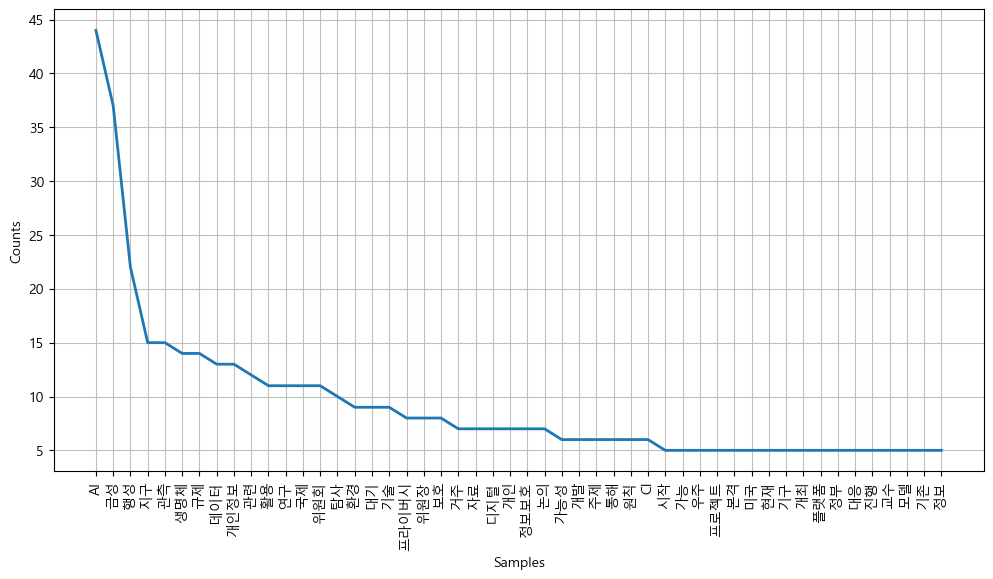

In [128]:

news = nltk.Text(tokens, name="네이버 경제 뉴스")
plt.figure(figsize=(12, 6))
news.plot(50)
plt.show()

In [129]:
# 가장 많이 나오는 단어 5개
data = news.vocab().most_common(5)
data

[('AI', 44), ('금성', 37), ('행성', 22), ('지구', 15), ('관측', 15)]

In [130]:
from PIL import Image
mask = np.array(Image.open('../static/img/data_science1.jpg'))
from wordcloud import ImageColorGenerator
image_colors = ImageColorGenerator(mask)

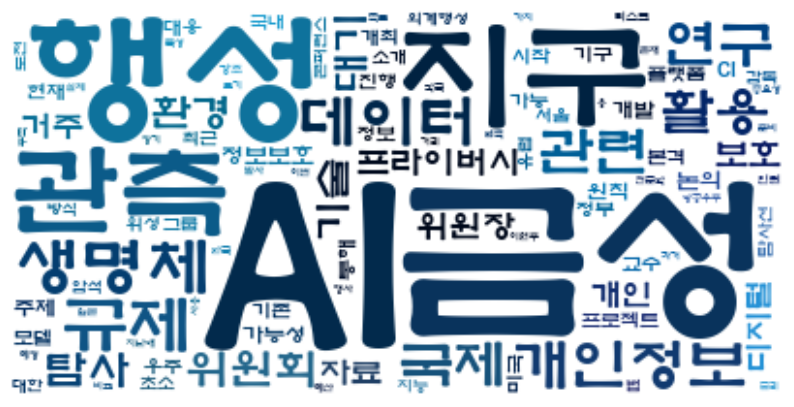

In [131]:
# 워드 클라우드 그리기
wc = WordCloud(
    background_color='white', 
    random_state=2023,
    font_path='C:/Windows/Fonts/HMFMOLD.TTF', 
).generate_from_frequencies(dict(news.vocab().most_common(100)))

plt.figure(figsize=(10, 6))
plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()